In [1]:
import numpy as np
import torch
import pandas as pd
import random 

import sys
sys.path.insert(1,'./')
from EmbeddedRegions import EmbeddedRegions

def reduce_coord_info(coord_info,geos,organisms,cell_types,cell_numbers,chroms,replicates):
    '''
    Reduce the coord_info object to the rows that satisfy all desired restrictions. 
    '''

    key_vals = {
        'Accession':geos,
        'Organism':organisms,
        'Cell_Type':cell_types,
        'Cell':cell_numbers,
        'Replicate':replicates,
        'Chromosome':chroms
    }

    for col, restrictions in key_vals.items():
        assert len(coord_info) > 0, "No data satisfies your desired restrictions."
        if restrictions is None:
            continue
        idx = np.zeros(len(coord_info),dtype=bool)
        vals = coord_info[col].values
        for r in restrictions: 
            idx|= vals == r
        idx = np.where(idx)[0]
        coord_info = coord_info.iloc[idx]

    # Reset the index in the coord_info DataFrame to make indexing it later more straightforward. 
    coord_info.reset_index(drop=True,inplace=True)
    
    return coord_info 

def load_coords(filepath,coord_info):

    index_ranges = [[coord_info['idx_min'].iloc[0],coord_info['idx_max'].iloc[0]+1]]
    for k,row in coord_info.iterrows(): 
        if k == 0:
            continue
        if index_ranges[-1][1] == row['idx_min']:
            index_ranges[-1][1] = row['idx_max']+1
        else: 
            index_ranges.append([row['idx_min'],row['idx_max']+1])

    data = []
    for range in index_ranges: 
        data.append(
            pd.read_hdf(
                filepath,
                key='Coordinates',
                start=range[0],
                stop=range[1]
            )
        )

    data = pd.concat(
        data,
        axis=0,
        ignore_index=True
    )
    data.reset_index(drop=True,inplace=True)
    
    return data

def get_valid_starts(permitted_lengths,segment_length,allow_overlap=False): 
        '''
        Find all indices where, including that bead, there are segment_length
        sequential beads in a row (i.e. not removed during Dip-C clean process)

        If allow_overlap is set to False, the indices returned will represent
        the starting points for non-overlapping regions only
        '''

        pl = permitted_lengths 
    
        # If overlapping regions are fine, simply need segments long enough
        # to satisfy the following 
        if allow_overlap:
            return np.where( pl > segment_length-2 )[0]

        # A monomer at the extreme end of one segment can appear as the start of the next 
        # segment per this setup 
        perlens_for_no_overlap = np.arange(segment_length-1,pl.max()+.5,segment_length-1)
        perlens_for_no_overlap = perlens_for_no_overlap.reshape(1,len(perlens_for_no_overlap))

        pl = pl.reshape(len(pl),1)
        return np.where( (pl == perlens_for_no_overlap).any(1) )[0]

def reset_coord_info_indices(coord_info):
    
    # Make the indices match the DataFrame containing actual coordinates 
    coord_info.loc[0,'idx_max'] = coord_info.loc[0,'idx_max'] - coord_info.loc[0,'idx_min']
    coord_info.loc[0,'idx_min'] = 0 
    for i in range(1,len(coord_info)):
        length = coord_info.loc[i,'idx_max'] - coord_info.loc[i,'idx_min']
        coord_info.loc[i,'idx_min'] = coord_info.loc[i-1,'idx_max'] + 1
        coord_info.loc[i,'idx_max'] = coord_info.loc[i,'idx_min'] + length

    return coord_info

class ConfigDataset:

    def __init__(
        self,
        filepath,
        segment_length=64,
        batch_size=64,
        normalize_distances=True,
        geos=None,
        organisms=None,
        cell_types=None,
        cell_numbers=None,
        chroms=None,
        replicates=None,
        shuffle=True,
        allow_overlap=False,
        two_channels=False,
        try_GPU=True,
        mean_dist_fp='../../data/mean_dists.pt',
        mean_sq_dist_fp='../../data/squares.pt',
        embedding_directory=None
    ):
        '''
        filepath: Dataset location. Should be formatted as designed for this study
        segment_length: The number of monomers relevant to the distance maps 
        batch_size: Number of configurations per batch 
        shuffle: Should the sample indices be shuffled before each epoch? 
        allow_overlap: Can the dataset include overlapping regions (True), 
                       or should they all be fully independent (False)? 
        two_channels: Does the data include the maternal & paternal structures
                        in the same sample (two channels of the image)? Otherwise, 
                        returns one or the other. 
        embedding_directory: Directory containing the relevant embedding tar.gz files

        To choose a subset of the overall dataset, use the following variables. In all cases, 
        a value of None means no restriction on this parameter. Otherwise, a list of those 
        parameters to be INCLUDED should be provided. 
            1. geos: GEO accession numbers
            2. organisms: Organism, e.g. 'Human' or 'Mouse'
            3. cell_types: Cell type 
            4. cell_numbers: Cell number within a dataset specified above. Should be np.int64
            5. chroms: Chromosomes. Should be passed as a string. 
            6. replicates: Replicates from Dip-C procedure on the same cell's data
        '''

        # Assign qualities where relevant 
        self.filepath = filepath 
        self.seg_len = segment_length 
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.allow_overlap = allow_overlap
        self.two_channels = two_channels
        self.norm_dists = normalize_distances

        # torch.cuda.is_available() doesn't work properly on 
        # SuperCloud, so use this approach instead. 
        try: 
            assert try_GPU
            self.device = torch.empty(1).cuda().device
        except:
            self.device = torch.empty(1).device

        # Load the information object to help us decide which portion of the dataset to load from storage
        coord_info = pd.read_hdf(
            self.filepath,
            key='coord_info'
        )

        # Find the indices to load from memory
        coord_info = reduce_coord_info(coord_info,geos,organisms,cell_types,cell_numbers,chroms,replicates)

        # Fetch the desired rows from memory
        coord_df = load_coords(filepath,coord_info)

        # Place information from the coord_df object into objects which improve speed downstream 
        self.coords = torch.from_numpy(coord_df[['mat_x','mat_y','mat_z','pat_x','pat_y','pat_z']].values).to(torch.double)
        self.genomic_index = coord_df['Genomic_Index'].values

        # Get the indices of valid starting positions to obtain uninterrupted regions of the referenced dimensions
        self.start_indices = get_valid_starts(coord_df['Permitted_Lengths'].values,segment_length,allow_overlap)

        # Set the indices of the coord_info object to match the loaded dataset
        self.coord_info = reset_coord_info_indices(coord_info)

        # Track the sample indices. This can be shuffled without perturbing the main dataset 
        #self.data_index = 
        if two_channels: 
            self.data_index = self.start_indices
        else: 
            n = len(self.start_indices)
            self.data_index = np.empty((2*n,2),dtype=np.int64)
            self.data_index[:n,0] = self.start_indices # Rows in coords object
            self.data_index[:n,1] = 0 # Maternal is in columns 0,1,2
            self.data_index[n:,0] = self.start_indices 
            self.data_index[n:,1] = 3 # Paternal is in columns 3,4,5

        # Define some internal indexing objects to keep track of the dataset
        self.epoch = 0     # Which epoch are we on? 
        self.inner_idx = 0 # Keep track of which row in the dataset we're considering
        self.reset_index() # This will shuffle the index (if desired) and increase epoch to 1
        self.triu_indices = torch.triu_indices(segment_length,segment_length,1) 

        # The following is used to index the distance objects, which are indexed such that
        # sep[i] corresponds to i+1, so subtract the 1
        self.sep_idx = self.triu_indices[1] - self.triu_indices[0] - 1  
        

        # Initialize some objects used during batch fetching/manipulation
        self.batch_coords = torch.empty(self.batch_size,self.seg_len,3*(1+int(self.two_channels)),
                                        device=self.device,dtype=self.coords.dtype)
        self.batch_dists = torch.empty(self.batch_size,1+int(self.two_channels),self.seg_len-1,self.seg_len-1,
                                      device=self.device,dtype=torch.float)

        # Load the distance vs genomic separation relationships used to normalize the distance data
        # for use in the signmoid mod. Afterwards, process the values we use at each iteration
        dt = self.batch_coords.dtype
        mean_dist = torch.load(mean_dist_fp,map_location=self.device).flatten()[:self.seg_len].to(dt)
        mean_square_dist = torch.load(mean_sq_dist_fp,map_location=self.device).flatten()[:self.seg_len].to(dt)
        self.dist_std = (mean_square_dist - mean_dist**2).sqrt()
        self.inv_beta = torch.sqrt( 2*mean_square_dist/3 )
        self.inv_beta_sigmoid = torch.sigmoid( -self.inv_beta/self.dist_std )
        self.complement_inv_beta_sigmoid = 1 - self.inv_beta_sigmoid

    def reset_index(self):

        if self.shuffle: 
            n_unused = len(self) - self.inner_idx
            if n_unused > 0 and n_unused < self.batch_size: 
                # Place the unused data at the front, if the epoch
                # hasn't *totally* completed but is less than a 
                # batch length away. 
                temp = self.data_index[-n_unused:,...].copy()
                idx = np.arange(len(self)-n_unused)
                self.data_index[n_unused:,...] = self.data_index[idx,...]
                self.data_index[:n_unused,...] = temp 
            else:
                idx = np.arange(self.data_index.shape[0])
                random.shuffle(idx)
                self.data_index = self.data_index[idx,...]

        self.epoch+=1
        self.inner_idx = 0

    def normalize_dists(self,dists):
        if not self.norm_dists:
            return dists
        sep = self.sep_idx
        i,j = self.triu_indices
        bs = self.batch_size
        j = j-1
        dists-= self.inv_beta[sep].repeat(bs,1)
        dists/= self.dist_std[sep].repeat(bs,1)
        dists.sigmoid_()
        dists-= self.inv_beta_sigmoid[sep].repeat(bs,1)
        dists/= self.complement_inv_beta_sigmoid[sep].repeat(bs,1)
        return dists 
        
    def get_genomic_regions(self):
    
        coord_info = self.coord_info
        start_indices = self.start_indices
        gen_idx = self.genomic_index
        nbeads = self.seg_len
    
        regions = pd.DataFrame({
            'Start':gen_idx[start_indices]
        })
        regions['Stop'] = regions['Start'] + (gen_idx[start_indices[0]+1] - gen_idx[start_indices[0]]) * self.seg_len
        regions.insert(0,'Chromosome','')
    
        for _,row in coord_info.iterrows():
            idx = (start_indices >= row['idx_min']) & (start_indices <= row['idx_max'])
            if idx.any(): 
                regions.loc[idx,'Chromosome'] = row['Chromosome']
    
        regions.drop_duplicates(ignore_index=True,inplace=True)
        
        return regions

    def fetch_coords(self,start_idx): 
        
        if type(start_idx) == tuple: 
            #assert start[1] in ['mat','pat']
            y = start_idx[0]
            x_idxs = [3*(start_idx[1] == 'pat')]
        else:
            y = start_idx
            x_idxs = [0,3] 

        coords = []
        for x_idx in x_idxs: 
            coords.append(self.coords[y:y+self.seg_len,x_idx:x_idx+3])

        return torch.stack(coords,dim=0)
            

    def fetch(self,start_indices):

        # Get the relevant coordinates
        if type(start_indices) == int or type(start_indices) == tuple: 
            start_indices = [start_indices]

        coords = torch.stack([self.fetch_coords(i) for i in start_indices],dim=0).to(self.device)

        # Compute distances; ignore duplicates
        i,j = self.triu_indices
        dists = torch.cdist(coords,coords)[...,i,j]

        # Normalize distances (if desired) 
        if self.norm_dists: 
            s = dists.shape
            dists = dl.normalize_dists(dists.flatten(0,-2)).to(dl.batch_dists.dtype).reshape(s)

        b,c,h = dists.shape[0],dists.shape[1],self.seg_len-1
        batch = torch.empty((b,c,h,h),dtype=torch.float,device=self.device)
        j = j-1
        batch[:,:,i,j] = dists.to(torch.float)
        batch[:,:,j,i] = dists.to(torch.float)
        
        return batch 
        
    def __len__(self):
        return self.data_index.shape[0]
    
    def __next__(self):

        # Avoid out of range issues
        if self.inner_idx + self.batch_size >= len(self):
            self.reset_index()

        # Get the section of the main dataset we're pulling from 
        idx = self.data_index[self.inner_idx:self.inner_idx+self.batch_size,...]
        
        # Get the distance map associated with the inquired regions
        if self.two_channels:
            for i,j in enumerate(idx): 
                self.batch_coords[i,...] = self.coords[j:j+self.seg_len,:]
        else:
            for i in range(self.batch_size):
                i0 = idx[i,0]
                i1 = idx[i,1]
                self.batch_coords[i,:,:] = self.coords[i0:i0+self.seg_len,i1:i1+3]
                #self.batch_coords[sub_idx,i,:] = self.coords[idx[sub_idx,0],:3].to(self.device).reshape_as(self.batch_coords[sub_idx,:,:])
                #sub_idx^= True # Flips to paternal index
                #self.batch_coords[sub_idx,i,:] = self.coords[idx[sub_idx,0],3:].to(self.device).reshape_as(self.batch_coords[sub_idx,:,:])

        i,j = self.triu_indices
        for k in range(self.batch_dists.shape[1]):
            ii = 3*k
            jj = ii+3
            dists = torch.cdist(self.batch_coords[:,:,ii:jj],self.batch_coords[:,:,ii:jj])[:,i,j]
            self.batch_dists[:,k,i,j-1] = self.normalize_dists(dists).to(self.batch_dists.dtype) 
        self.batch_dists[:,:,j-1,i] = self.batch_dists[:,:,i,j-1]

        self.inner_idx+= self.batch_size 

        return self.batch_dists 
            
        
        

In [5]:
filepath = '../../data/processed_data.hdf5'
dl = ConfigDataset(
    filepath,
    segment_length=65,
    batch_size=64,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=True,
    allow_overlap=False,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp='../../data/mean_dists.pt',
    mean_sq_dist_fp='../../data/squares.pt'
)

In [6]:
import matplotlib.pyplot as plt

In [7]:
batch = next(dl)

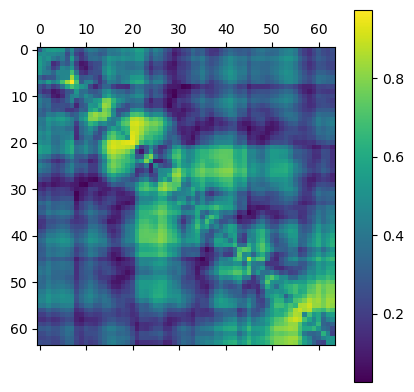

In [8]:
n = 0
plt.matshow(batch[n,0,...].numpy())#,vmin=0,vmax=1)
plt.colorbar()

In [10]:
idx = []
iidx = dl.data_index[0:64,:]
for i in range(64):
    lin = 'mat' if iidx[i,1]==0 else 'pat'
    idx.append((iidx[i,0],lin))

#batch1 = fetch(dl,idx)#dl.fetch(idx)
batch1 = dl.fetch(idx)
assert (batch==batch1).all()

In [11]:
er = EmbeddedRegions('../../data/embeddings/',chroms=['X'])

In [14]:
class DataLoader:

    def __init__(
        self,
        config_ds,
        embedded_regions=None,
        drop_unmatched_pairs=True, # Should we drop the unneeded rows in the embedder object?
        shuffle = True,
        batch_size=64
    ):

        '''
        NOTE: This assumes that any unmatched region lengths have already been removed from the embeddedregions
        object. 
        '''

        # Basic attributes
        self.configs = config_ds
        self.embedded_regions = embedded_regions
        self.shuffle = shuffle
        self.batch_size = batch_size 
        self.epoch = 0 
        self.internal_idx = 0 
        
        # Ease our notation. 
        con, er = self.configs, self.embedded_regions
        
        # Ensure input objects are correct
        msg = ''
        if type(con) != ConfigDataset:
            msg+= f'Expected configurations to be a ConfigDataset object. Received {type(con)}.'
        if type(er) != EmbeddedRegions and er is not None: 
            if msg != '':
                msg+='\n'
            msg+=f'Expected embeddedregions to be an EmbeddedRegions object or NoneType. Received {type(er)}.'
        if len(er.length_index.unique()) > 1: 
            if msg != '':
                msg+='\n'
            msg+= f'The EmbeddedRegions object must have only one region to match the capabilities of the Coordinates object.'
        if msg!= '':
            raise Exception(msg) 
        
        # Combine the relevant information from con into a DataFrame for easy manipulation/
        df = pd.DataFrame()
        df['coord_idx'] = con.start_indices # Starting position, first index position of con.coords
        df['Chromosome'] = ''
        df['Genomic_Index'] = con.genomic_index[con.start_indices] # Starting position, genomic index of chromosome
        
        # Fill in the chromosome position
        s = df['coord_idx'] 
        todo = np.ones(len(df),dtype=bool) # Saves some time with comparisons in the loop
        for _,row in con.coord_info.iterrows():
            idx = todo & (s <= row['idx_max']) & (s >= row['idx_min'])
            df.loc[idx,'Chromosome'] = row['Chromosome'] 
            todo&= ~idx

        # Handle the EmbeddedRegions object's indices, if it exists
        if er is not None: 
            # Place the data in a DataFrame for easy comparison with the configuration data
            df2 = pd.DataFrame()
            df2['Chromosome'] = er.chrom_index.values
            df2['Genomic_Index'] = er.genomic_index.values

            # Free memory by dropping the unused embeddings
            if drop_unmatched_pairs: 
                #drop_idx = er.index[df.merge(df2,indicator=True,how='right')['_merge'] == 'right_only']
                drop_idx = df2.merge(df,indicator=True,how='left')
                drop_idx = drop_idx[ drop_idx['_merge'].values == 'left_only' ][['Chromosome','Genomic_Index']].drop_duplicates()
                drop_idx = [(er.length_index[0],*drop_idx.iloc[i].values) for i in range(len(drop_idx))]
                self.embedded_regions.drop(index=drop_idx) # Pretty sure we can just do er.drop, but pointer vs not always gets me...
                del drop_idx

            # This reduces our choices to the regions present in both objects 
            df = df.merge(df2,how='inner')
            del df2

            # Get the index for embedding
            length = er.length_index[0]
            embed_idx = np.array([
                [length for k in range(len(df))],
                df['Chromosome'].values,
                df['Genomic_Index'].values
            ]).T
            df['embed_idx'] = pd.MultiIndex.from_tuples(
                list(map(tuple,embed_idx)),
                names=list(er.index.names)
            )
            del embed_idx

        if not con.two_channels: 
            # Must account for maternal vs paternal copies/duplicates
            idx1 = df['coord_idx'].values
            coord_idx = [(i,'mat') for i in idx1]
            coord_idx.extend([(i,'pat') for i in idx1])
            df = pd.concat([df,df])
            df['coord_idx'] = coord_idx
            del coord_idx 

        # Finally, make the index an attribute of this object and 
        # shuffle the index for the first epoch (if desired). 
        self.index = df
        if shuffle: 
            self.reshuffle()

    @property
    def embed_idx(self):
        return self.index['embed_idx']

    @property
    def coord_idx(self):
        return self.index['coord_idx']

    def __len__(self):
        return len(self.index)
        
    def reshuffle(self):
        self.index = self.index.sample(frac=1)

    def reset_index(self):
        self.internal_index = 0
        self.epoch+= 1
        if self.shuffle:
            self.reshuffle()

    def __next__(self):
        i = self.internal_idx
        j = min(i+self.batch_size,len(self))

        # Get the embeddings (if desired) 
        if self.embedded_regions is None:
            embeddings = None
        else:
            embeddings = self.embedded_regions.fetch(self.embed_idx[i:j])
            if j-i == 1:
                embeddings = embeddings.reshape(1,*embeddings.shape)
            else:
                embeddings = torch.stack(embeddings,0)

        # Get the distance maps 
        dist_maps = self.configs.fetch(self.coord_idx[i:j].tolist())
        
        # Reset the index, if necessary
        if j == len(self):
            self.reset_index()

        return dist_maps, embeddings 
    
        

In [15]:
ddl = DataLoader(dl,er)

In [16]:
dists,embeddings = next(ddl)

In [17]:
embeddings.shape

torch.Size([64, 1, 260, 256])

In [19]:
er.index[0]

(1300000, 'X', 300000)

In [21]:
er.fetch(er.index[0])

TypeError: 'builtin_function_or_method' object is not iterable

In [34]:
idx = er.index[:10]
type(er.data.loc[idx,'Data'])

pandas.core.series.Series

In [33]:
idx = er.index[0]
type(er.data.loc[idx,'Data']) == torch.Tensor

True

In [ ]:
er.index[df.merge(df2,indicator=True,how='right')['_merge'] == 'right_only']

In [55]:
for k in er.index.drop_duplicates():
    print(type(k))
    break

<class 'tuple'>


In [40]:
df = pd.DataFrame()
df['coord_idx'] = dl.start_indices

In [54]:
df['coord_idx'].values
len(pd.concat([df,df]))
len(df)

96924

In [51]:
list(map(tuple,np.array((s,['mat' for _ in range(len(s))])).T))

[('62', 'mat'),
 ('126', 'mat'),
 ('190', 'mat'),
 ('254', 'mat'),
 ('318', 'mat'),
 ('382', 'mat'),
 ('446', 'mat'),
 ('510', 'mat'),
 ('600', 'mat'),
 ('664', 'mat'),
 ('728', 'mat'),
 ('792', 'mat'),
 ('856', 'mat'),
 ('920', 'mat'),
 ('1093', 'mat'),
 ('1157', 'mat'),
 ('1221', 'mat'),
 ('1285', 'mat'),
 ('1349', 'mat'),
 ('1458', 'mat'),
 ('1522', 'mat'),
 ('1586', 'mat'),
 ('1650', 'mat'),
 ('1714', 'mat'),
 ('1778', 'mat'),
 ('1842', 'mat'),
 ('1906', 'mat'),
 ('1970', 'mat'),
 ('2034', 'mat'),
 ('2098', 'mat'),
 ('2162', 'mat'),
 ('2226', 'mat'),
 ('2290', 'mat'),
 ('2354', 'mat'),
 ('2418', 'mat'),
 ('2482', 'mat'),
 ('2546', 'mat'),
 ('2610', 'mat'),
 ('2674', 'mat'),
 ('2738', 'mat'),
 ('2802', 'mat'),
 ('2866', 'mat'),
 ('2930', 'mat'),
 ('2994', 'mat'),
 ('3058', 'mat'),
 ('3122', 'mat'),
 ('3186', 'mat'),
 ('3250', 'mat'),
 ('3314', 'mat'),
 ('3378', 'mat'),
 ('3442', 'mat'),
 ('3506', 'mat'),
 ('3570', 'mat'),
 ('3634', 'mat'),
 ('3698', 'mat'),
 ('3762', 'mat'),
 ('3826

In [50]:
s = df['coord_idx'].values.copy()
list(map(tuple,
         (s,['mat' for _ in range(len(s))])))



[(62,
  126,
  190,
  254,
  318,
  382,
  446,
  510,
  600,
  664,
  728,
  792,
  856,
  920,
  1093,
  1157,
  1221,
  1285,
  1349,
  1458,
  1522,
  1586,
  1650,
  1714,
  1778,
  1842,
  1906,
  1970,
  2034,
  2098,
  2162,
  2226,
  2290,
  2354,
  2418,
  2482,
  2546,
  2610,
  2674,
  2738,
  2802,
  2866,
  2930,
  2994,
  3058,
  3122,
  3186,
  3250,
  3314,
  3378,
  3442,
  3506,
  3570,
  3634,
  3698,
  3762,
  3826,
  3890,
  3954,
  4018,
  4082,
  4146,
  4210,
  4274,
  4338,
  4402,
  4466,
  4530,
  4594,
  4658,
  4722,
  4786,
  4850,
  4914,
  4978,
  5042,
  5106,
  5170,
  5234,
  5298,
  5362,
  5426,
  5490,
  5554,
  5618,
  5682,
  5746,
  5832,
  5896,
  5960,
  6024,
  6088,
  6152,
  6216,
  6280,
  6344,
  6408,
  6472,
  6536,
  6600,
  6664,
  6728,
  6792,
  6856,
  6920,
  6984,
  7048,
  7112,
  7176,
  7240,
  7304,
  7368,
  7432,
  7496,
  7560,
  7624,
  7688,
  7752,
  7816,
  7880,
  7944,
  8008,
  8072,
  8136,
  8200,
  8264,
  8328,

In [39]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df['test'] = [1,2,3,4,5,6]
df2['test'] = [1,2,3,4,5,6,1,2,3,4,5,6]
df.merge(df2,indicator=True,how='left')['_merge'].values == 'left_only'

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
import torch

In [18]:
torch.stack(a.values[0],dim=0)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [66]:
s = df['Start'] 
n=0 
t = -time.time()
for _,row in dl.coord_info.iterrows():
    idx = (s <= row['idx_max']) & (s >= row['idx_min'])
    df.loc[idx,'Chromosome'] = row['Chromosome'] 
t+= time.time()
t

0.7449564933776855

In [65]:
import time
s = df['Start'].values
try:
    df.drop(columns=['Chrom2'],inplace=True) 
except:
    pass
df.insert(1,'Chrom2','')
todo = np.ones(len(df),dtype=bool) # Should save some time with comparisons in the loop
t = -time.time()
for _,row in dl.coord_info.iterrows():
    idx = todo & (s <= row['idx_max']) & (s >= row['idx_min'])
    df.loc[idx,'Chrom2'] = row['Chromosome'] 
    todo&= ~idx
t+= time.time()
assert (df['Chromosome'].values == df['Chrom2'].values).all()
t

0.49672365188598633

In [108]:
a = pd.DataFrame()
b = pd.DataFrame()
a['Chrom'] = [1,2,3,4,5]
b['Chrom'] = a['Chrom']
b['Chrom2'] = b['Chrom']
b.loc[len(b),'Chrom'] = 6
a.merge(b,indicator=True,how='inner')#['_merge']=='right_only'

,Chrom,Chrom2,_merge
0,1,1.0,both
1,2,2.0,both
2,3,3.0,both
3,4,4.0,both
4,5,5.0,both


In [89]:
er.chrom_index.values

array(['X', 'X', 'X', ..., 'X', 'X', 'X'], dtype=object)

In [22]:
er = EmbeddedRegions('../../data/embeddings/',chroms=['X'])


In [27]:
er.index

MultiIndex([(1300000, 'X',    220000),
            (1300000, 'X',    240000),
            (1300000, 'X',    260000),
            (1300000, 'X',    280000),
            (1300000, 'X',    300000),
            (1300000, 'X',    320000),
            (1300000, 'X',    340000),
            (1300000, 'X',    360000),
            (1300000, 'X',    380000),
            (1300000, 'X',    400000),
            ...
            (1300000, 'X', 153780000),
            (1300000, 'X', 153800000),
            (1300000, 'X', 153820000),
            (1300000, 'X', 153840000),
            (1300000, 'X', 153860000),
            (1300000, 'X', 153880000),
            (1300000, 'X', 153900000),
            (1300000, 'X', 153920000),
            (1300000, 'X', 153940000),
            (1300000, 'X', 153960000)],
           names=['Region_Length', 'Chromosome', 'Genomic_Index'], length=7271)

In [71]:
filepath = '../../data/processed_data.hdf5'
dl = DataLoader(
    filepath,
    segment_length=129,
    batch_size=64,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=True,
    allow_overlap=False,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp='../../data/mean_dists.pt',
    mean_sq_dist_fp='../../data/squares.pt'
)

In [28]:
torch.load('../../data/seps.pt').shape

torch.Size([64])

In [55]:
dl.reset_index()
dl.epoch = 1
t = next(dl).double()
averages = t.mean(0) 
squares = t.square().mean(0)
N = 0 
while dl.epoch == 1: 
    t = next(dl).double()
    averages+= t.mean(0)
    squares+= t.square().mean(0)
    N+=1
averages/= N
squares/= N
averages = averages.mean(0) 
squares = squares.mean(0) 

In [57]:
i,j = torch.triu_indices(averages.shape[-2],averages.shape[-1],0)
sep = j-i + 1
seps = sep.unique()
means = torch.empty(len(seps.unique())).double()
squares2 = means.clone()
for ii,s in enumerate(seps):
    idx = sep == s 
    means[ii] = averages[i,j][idx].mean()
    squares2[ii] = squares[i,j][idx].mean()

torch.save(seps.cpu(),'../../data/seps.pt') 
torch.save(means.cpu(),'../../data/mean_dists.pt')
torch.save(squares2.cpu(),'../../data/squares.pt') 

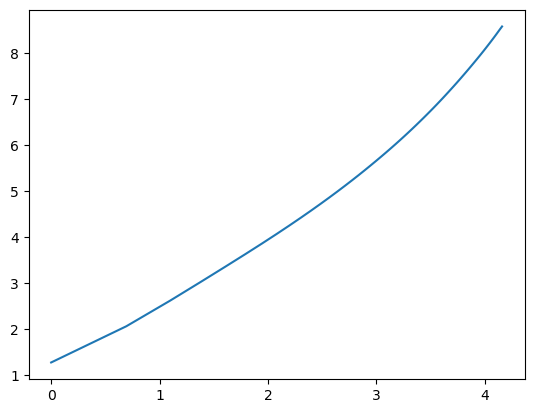

In [62]:
plt.plot(torch.log(seps),means)

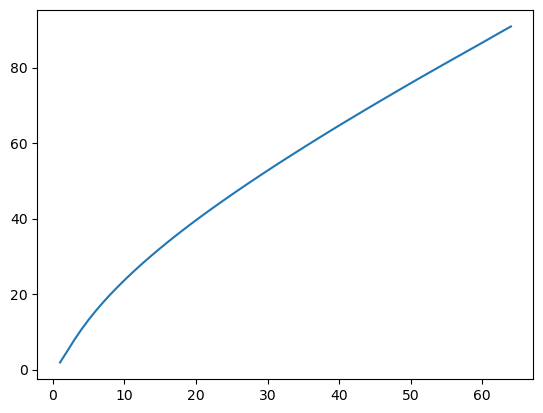

In [59]:
plt.plot(seps,squares2)

In [58]:
import time
import matplotlib.pyplot as plt

ntrials = 1000
ts = []
for _ in range(ntrials):
    t = time.time()
    _ = next(dl)
    t-= time.time()
    ts.append(-t)
print(np.mean(ts))
print(np.std(ts))
print(np.min(ts))
print(np.max(ts))

0.0027201809883117675
0.0010701711082512896
0.0019865036010742188
0.026117563247680664


(array([979.,  13.,   0.,   6.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.0019865 , 0.00439961, 0.00681272, 0.00922582, 0.01163893,
        0.01405203, 0.01646514, 0.01887825, 0.02129135, 0.02370446,
        0.02611756]),
 <BarContainer object of 10 artists>)

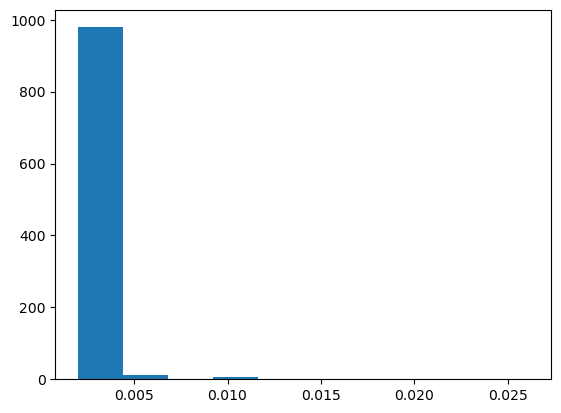

In [59]:
plt.hist(ts)

In [60]:
batch = next(dl)

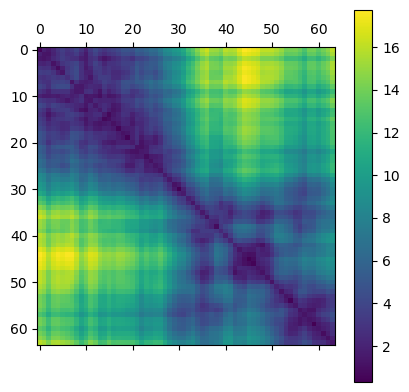

In [66]:
plt.matshow(batch[50,0,...].numpy())
plt.colorbar()